<a href="https://colab.research.google.com/github/abulhasanat/MachineLearning/blob/master/sentiment_analysis_with_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

     |████████████████████████████████| 665kB 3.4MB/s 
     |████████████████████████████████| 890kB 15.1MB/s 
     |████████████████████████████████| 3.8MB 22.7MB/s 
     |████████████████████████████████| 1.1MB 31.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=94a1d484f71ee8be7c3c1298c77b2e5ea97cc7f8ffab8c6ed32314062fcec7e5
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


device(type='cuda', index=0)

In [3]:
df = pd.read_csv("/content/drive/My Drive/Data/Google Play Review/reviews.csv")
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOGt2KEhc-yNMmOBsXqfHKLGJ-vDENQPVPlGZIM...,Earl Clark,https://lh3.googleusercontent.com/a-/AOh14Gj_X...,"This is an expensive app. That being said, it'...",1,120,5.0.0.11,2020-05-16 15:23:38,We are not aware of any issues with editing ta...,2020-05-17 10:06:29,most_relevant,com.anydo
1,gp:AOqpTOFnIu5LAl0bREEIRnyqUs95zFeDP4kQ-eY638E...,Elad Posner,https://lh3.googleusercontent.com/a-/AOh14Ghzk...,Something is wrong with the last version. Sinc...,1,153,5.0.0.11,2020-05-08 11:48:18,Sorry about that. Please uninstall and reinsta...,2020-05-10 09:25:36,most_relevant,com.anydo
2,gp:AOqpTOE4go3obyJs27PrDvsA_mPKmlYD_muUNj3NHNA...,Checaii Garcia,https://lh3.googleusercontent.com/a-/AOh14GiQ8...,I wanted to try the app but it never opens. I ...,1,30,5.0.0.11,2020-05-08 08:26:34,Sorry about that! Please feel free to contact ...,2020-05-10 09:20:14,most_relevant,com.anydo
3,gp:AOqpTOF_OBDJpMDUE3xGa8fbyCJDD3mM8z5AGNSIf4q...,Dominic Flanagan,https://lh3.googleusercontent.com/a-/AOh14Gjk1...,Pretty basic for the price. Lacks customisatio...,1,1,5.1.1.13,2020-05-28 16:23:37,Be advised that Any.do is a minimalistic task ...,2020-05-31 09:01:09,most_relevant,com.anydo
4,gp:AOqpTOF3Kb-6IdEeeYLcuUncmzjQdtNguLU5GTshqNY...,A Traveller,https://lh3.googleusercontent.com/-yutN8c-KH6U...,This app is a prime example of building a moun...,1,17,5.0.0.11,2020-05-09 17:20:56,If you're having trouble figuring out how to t...,2020-05-12 08:22:05,most_relevant,com.anydo


In [4]:
df.shape

(15926, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15926 entries, 0 to 15925
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              15926 non-null  object
 1   userName              15926 non-null  object
 2   userImage             15926 non-null  object
 3   content               15926 non-null  object
 4   score                 15926 non-null  int64 
 5   thumbsUpCount         15926 non-null  int64 
 6   reviewCreatedVersion  13680 non-null  object
 7   at                    15926 non-null  object
 8   replyContent          7891 non-null   object
 9   repliedAt             7891 non-null   object
 10  sortOrder             15926 non-null  object
 11  appId                 15926 non-null  object
dtypes: int64(2), object(10)
memory usage: 1.5+ MB


Text(0.5, 0, 'review score')

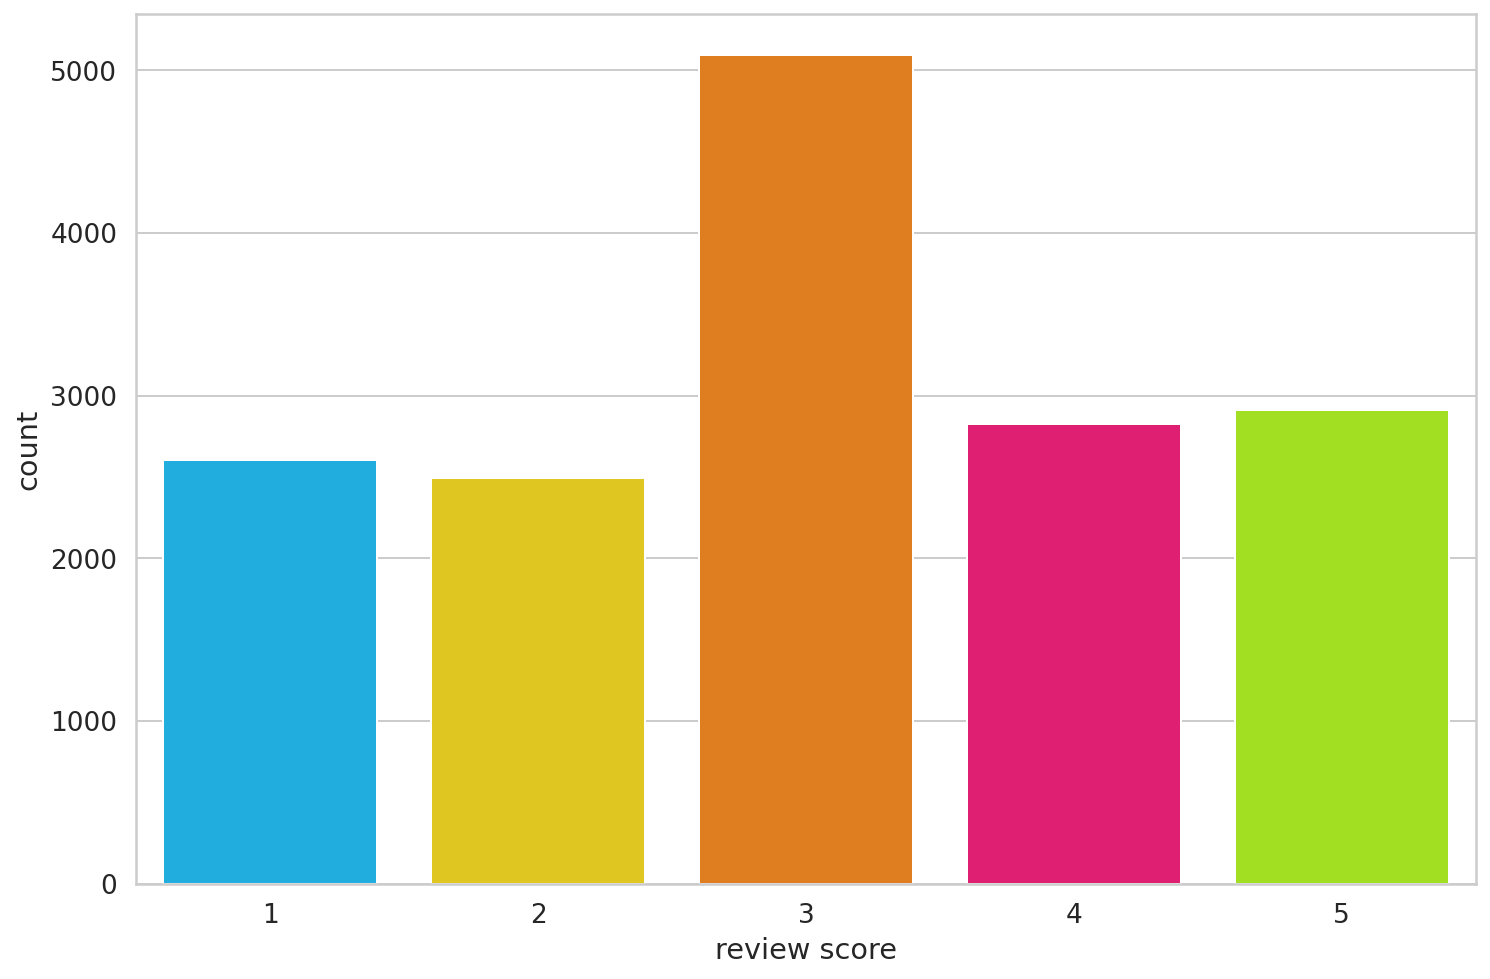

In [6]:
sns.countplot(df.score)
plt.xlabel('review score')

In [0]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [0]:
class_names = ['negative', 'neutral', 'positive']

[Text(0, 0, 'negative'), Text(0, 0, 'neutral'), Text(0, 0, 'positive')]

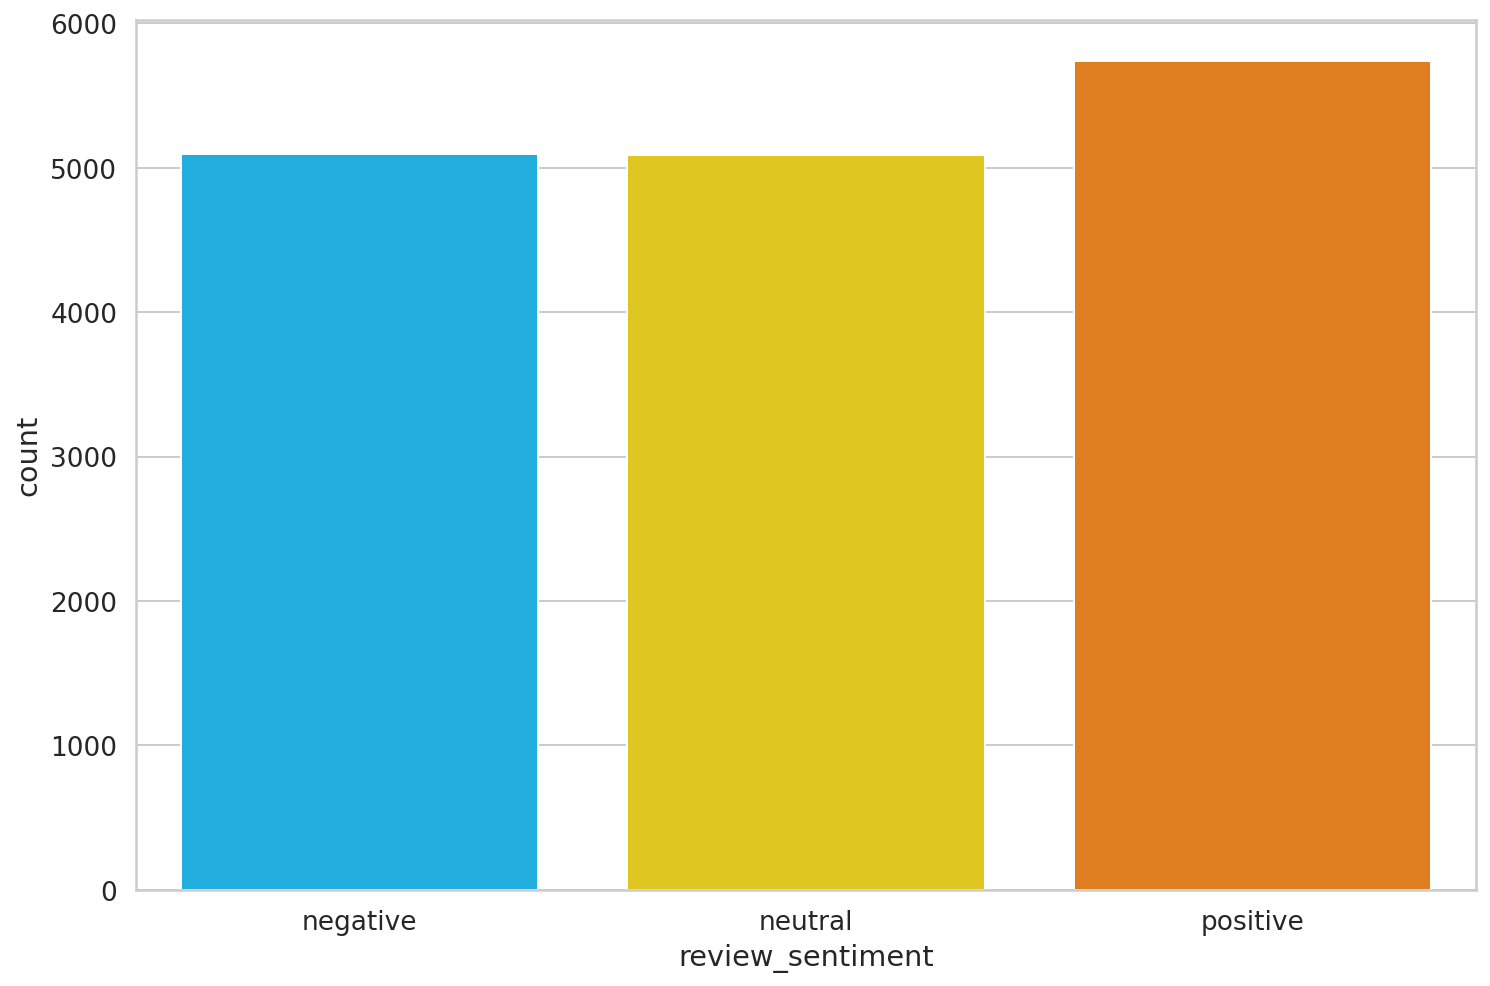

In [9]:
ax=sns.countplot(df.sentiment)
plt.xlabel('review_sentiment')
ax.set_xticklabels(class_names)

# Data Preprocessing

You might already know that Machine Learning models don't work with raw text. You need to convert text to numbers (of some sort). BERT requires even more attention (good one, right?). Here are the requirements:

Add special tokens to separate sentences and do classification
Pass sequences of constant length (introduce padding)
Create array of 0s (pad token) and 1s (real token) called attention mask
The Transformers library provides (you've guessed it) a wide variety of Transformer models (including BERT). It works with TensorFlow and PyTorch! It also includes prebuild tokenizers that do the heavy lifting for us!

In [0]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [38]:
tokenizer = transformers.BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [0]:
sample_txt='When was I last outside? I am stuck at home for 2 weeks.'

In [0]:
tokens=tokenizer.tokenize(sample_txt)

In [13]:
print(tokens)

['when', 'was', 'i', 'last', 'outside', '?', 'i', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']


In [0]:
token_ids=tokenizer.convert_tokens_to_ids(tokens)

In [15]:
print(token_ids)
print(len(token_ids))

[2043, 2001, 1045, 2197, 2648, 1029, 1045, 2572, 5881, 2012, 2188, 2005, 1016, 3134, 1012]
15


In [16]:
print(sample_txt)
print(tokens)
print(token_ids)

When was I last outside? I am stuck at home for 2 weeks.
['when', 'was', 'i', 'last', 'outside', '?', 'i', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
[2043, 2001, 1045, 2197, 2648, 1029, 1045, 2572, 5881, 2012, 2188, 2005, 1016, 3134, 1012]


### Special Tokens

In [17]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [18]:

tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [19]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [20]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [21]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [22]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 2043, 2001, 1045, 2197, 2648, 1029, 1045, 2572, 5881, 2012, 2188,
        2005, 1016, 3134, 1012,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [23]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [24]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'when',
 'was',
 'i',
 'last',
 'outside',
 '?',
 'i',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

### Choosing Sequence Length

BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review:

In [0]:
token_lens = []

for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Text(0.5, 0, 'Token count')

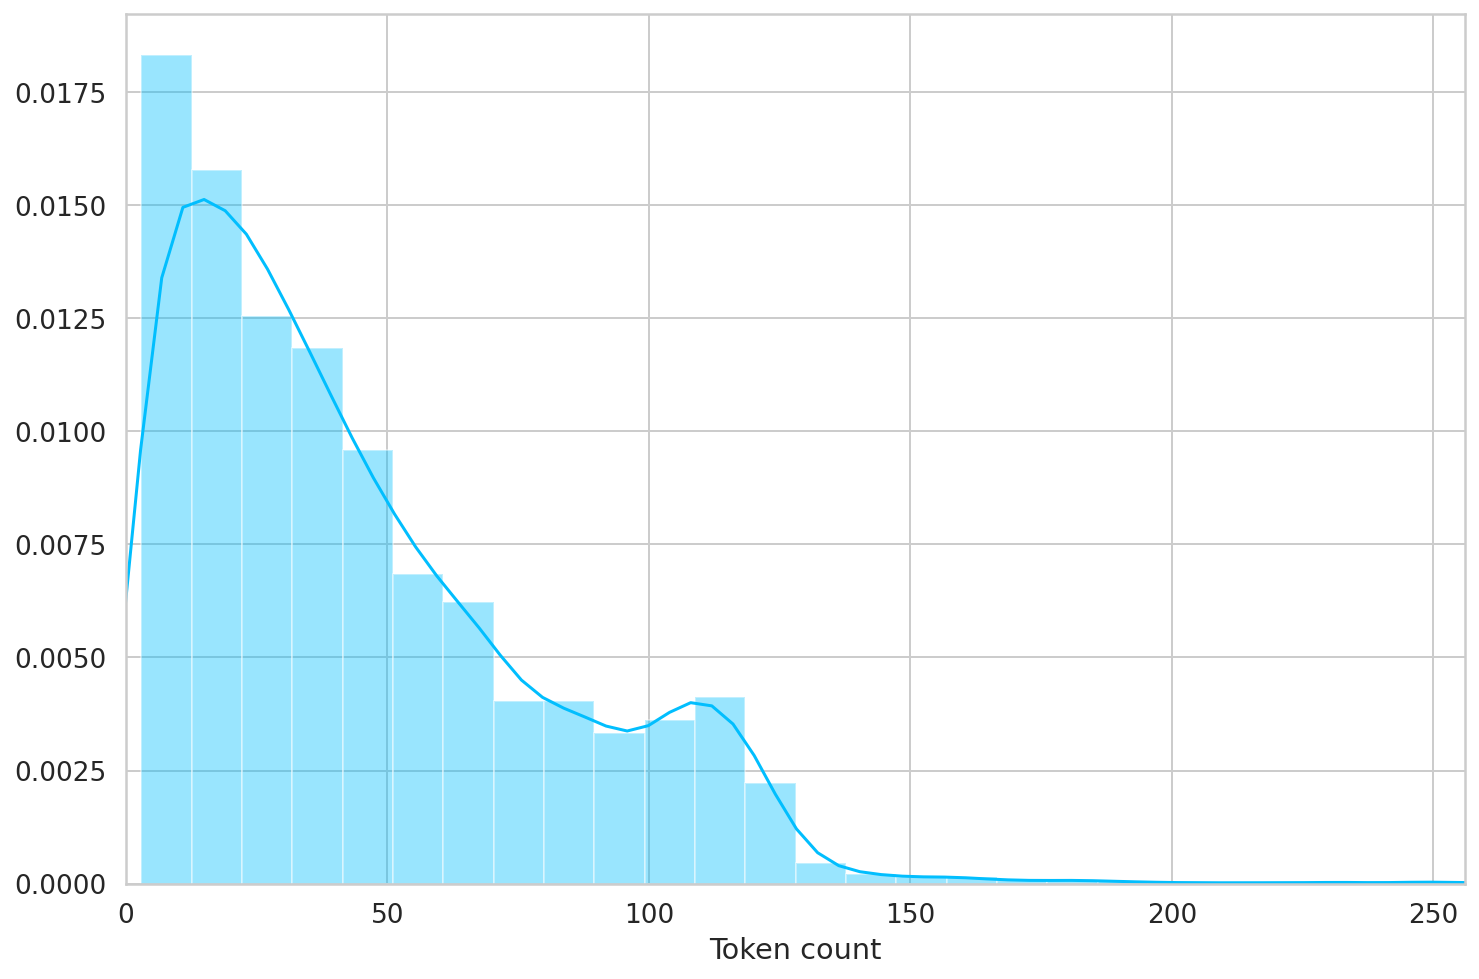

In [26]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

In [0]:
MAX_LEN = 160

In [0]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [0]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [30]:
df_train.shape, df_val.shape, df_test.shape

((14333, 13), (796, 13), (797, 13))

In [0]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [0]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [33]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [34]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


## Sentiment Classification with BERT and Hugging Face
There are a lot of helpers that make using BERT easy with the Transformers library. Depending on the task you might want to use BertForSequenceClassification, BertForQuestionAnswering or something else.

But who cares, right? We're hardcore! We'll use the basic BertModel and build our sentiment classifier on top of it. Let's load the model:

In [39]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [0]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

In [41]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [42]:
pooled_output.shape

torch.Size([1, 768])

In [0]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [0]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [45]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length


torch.Size([16, 160])
torch.Size([16, 160])


In [46]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4269, 0.1980, 0.3751],
        [0.4884, 0.1612, 0.3504],
        [0.2818, 0.1670, 0.5512],
        [0.5034, 0.1440, 0.3526],
        [0.5797, 0.1701, 0.2502],
        [0.3199, 0.2013, 0.4788],
        [0.3815, 0.1547, 0.4638],
        [0.2783, 0.2836, 0.4381],
        [0.3175, 0.1686, 0.5139],
        [0.2346, 0.2115, 0.5539],
        [0.4180, 0.2026, 0.3793],
        [0.3948, 0.2491, 0.3561],
        [0.5298, 0.1231, 0.3471],
        [0.4801, 0.2090, 0.3109],
        [0.4068, 0.1931, 0.4001],
        [0.3511, 0.2193, 0.4296]], device='cuda:0', grad_fn=<SoftmaxBackward>)

# Training

In [0]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [0]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [0]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [51]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), '/content/drive/My Drive/Data/Models/sentiment analysis/best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.6799370528398347 accuracy 0.7105979208818809
Val   loss 0.7544888716936111 accuracy 0.6834170854271356

Epoch 2/10
----------
Train loss 0.5097753935177545 accuracy 0.8072978441359101
Val   loss 0.7301386284828186 accuracy 0.7386934673366834

Epoch 3/10
----------
Train loss 0.37550796540121417 accuracy 0.8714853833810088
Val   loss 0.7691546058654786 accuracy 0.7613065326633166

Epoch 4/10
----------
Train loss 0.29662666670628823 accuracy 0.9061606083862415
Val   loss 0.8508723491430282 accuracy 0.7839195979899498

Epoch 5/10
----------
Train loss 0.23867029119927402 accuracy 0.9287657852508198
Val   loss 0.9017799423635006 accuracy 0.8128140703517588

Epoch 6/10
----------
Train loss 0.20243745912115887 accuracy 0.9447429009976975
Val   loss 0.9243114826083183 accuracy 0.8241206030150754

Epoch 7/10
----------
Train loss 0.17331175933733384 accuracy 0.9524872671457475
Val   loss 1.026999969780445 accuracy 0.8128140703517588

Epoch 8/10
----------
T